# Calculating Monthly Overdose deaths from CDC data
Author: Samir Akre
Last Updated: Jan 3 2021

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.load_data as ld
import src.defilter_data as dd
import src.estimate_error as ee
import importlib
import scipy.stats as stats

## Import and clean data
- 'predicted_val' column is 12-month rolling sum of monthly overdose deaths
- 'Deaths' column are the imputed monthly overdose deaths

In [3]:
importlib.reload(dd)
importlib.reload(ld)
data = ld.load_data().dropna(how='all')
data

,timestamp,location,predicted_val,Deaths
64,2015-01-01,Alabama,742,65.0
63,2015-02-01,Alabama,749,60.0
62,2015-03-01,Alabama,758,79.0
61,2015-04-01,Alabama,764,69.0
60,2015-05-01,Alabama,782,74.0
...,...,...,...,...
3252,2020-03-01,Wyoming,81,NaN
3251,2020-04-01,Wyoming,83,NaN
3250,2020-05-01,Wyoming,88,NaN
3365,2020-06-01,Wyoming,84,NaN


## Impute/Predict 2020 monthly data
- 11 months of monthly death data used to "unroll" to 12 month rolling sum reported for 2020 months

In [4]:
k = 12 # 12 month rolling sum
time_filt = data[data.timestamp >= pd.to_datetime('2019-01-01')]
time_filt['raw_predicted_val'] = np.nan
for loc in time_filt['location'].unique():
    truth = time_filt.loc[time_filt.location == loc, 'Deaths'].values
    pred = dd.defilter(time_filt.loc[data.location == loc, 'predicted_val'].iloc[11:].values, k, truth[:11])
    time_filt.loc[time_filt.location == loc, 'raw_predicted_val'] = pred
time_filt['raw_predicted_val'] = time_filt['raw_predicted_val'].astype(float)

<ipython-input-4-1b042708fa64>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filt['raw_predicted_val'] = np.nan
/Users/akre96/Code/cdc_overdose/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-4-1b042708fa64>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

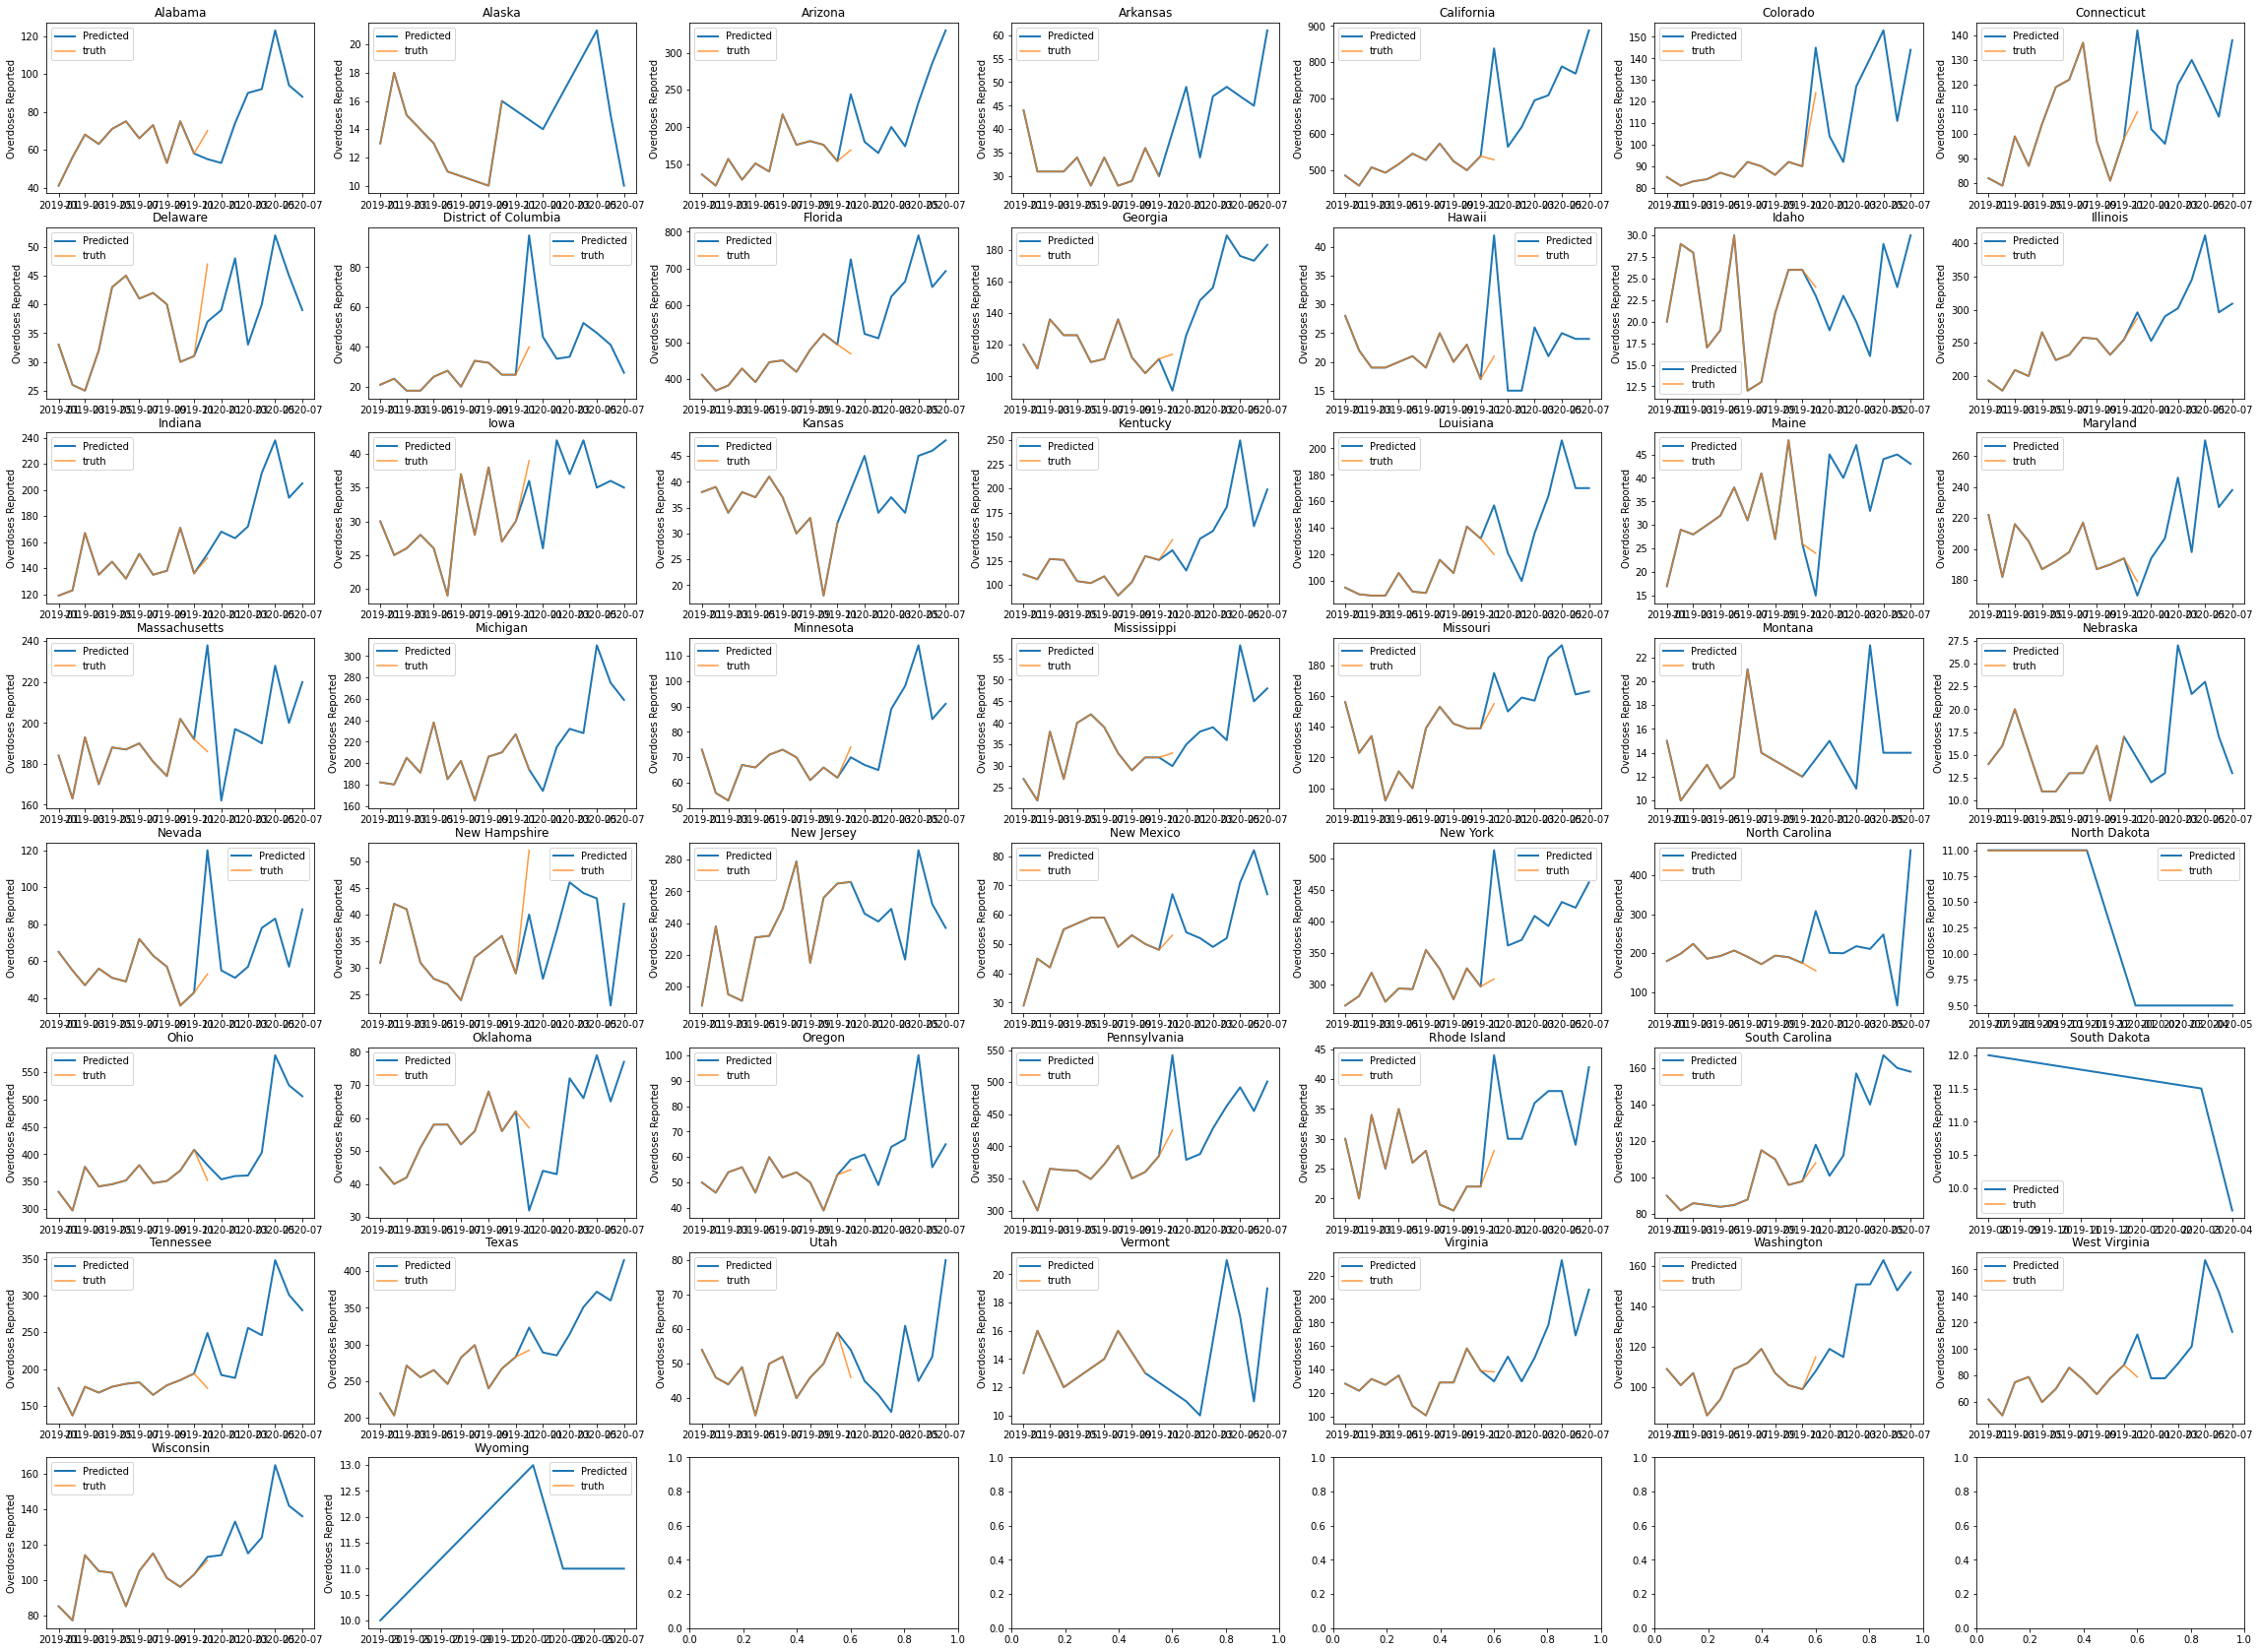

In [5]:
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(40,30))
i = 0
for loc, loc_data in time_filt.groupby('location'):
    ax=axes.flatten()[i]
    filt_data = loc_data.copy()
    # Hides values less than 10 from plot
    for col in ['raw_predicted_val', 'Deaths']:
        filt_data.loc[filt_data[col] <= 9] = np.nan
    sns.lineplot(
        x='timestamp',
        y='raw_predicted_val',
        data=filt_data,
        label='Predicted',
        markers=True,
        lw=2,
        ax=ax
    )
    sns.lineplot(
        x='timestamp',
        y='Deaths',
        data=filt_data,
        label='truth',
        markers=True,
        alpha=.8,
        ax=ax
    )
    ax.set_ylabel('Overdoses Reported')
    ax.set_title(loc)
    ax.set_xlabel('')
    i+=1

In [6]:
time_filt[[
    'location', 'Deaths', 'timestamp', 'raw_predicted_val'
]].to_csv('output/monthly_overdose_computed_m2.csv', index=False)

In [7]:
time_filt[time_filt.Deaths.isna()].groupby('timestamp').raw_predicted_val.sum()

timestamp
2020-01-01    6356.0
2020-02-01    6522.0
2020-03-01    7356.0
2020-04-01    7703.0
2020-05-01    9192.0
2020-06-01    7888.0
2020-07-01    8850.0
Name: raw_predicted_val, dtype: float64

# Error Analysis

## Testing rolling sum unrolling method

In [8]:
time = np.arange(0, 12*6)/12
truth = np.random.randint(0, 1000, size=time.shape)
truth = np.sin(time*2) + 1
cumTruth = pd.Series(truth).rolling(window=12).sum().values


<AxesSubplot:>

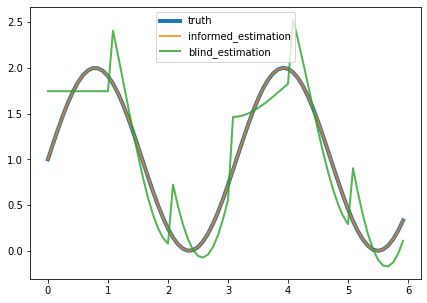

In [9]:
importlib.reload(dd)
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(
    x=time,
    y=truth,
    label='truth',
    lw=4,
    ax=ax
)
sns.lineplot(
    x=time,
    y=dd.defilter(cumTruth[11:], 12, truth[:11]),
    label='informed_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)

sns.lineplot(
    x=time,
    y=dd.defilter(cumTruth[12:], 12),
    label='blind_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)

## Discrepency in computed rolling sum of CDC monthly data vs reported rolling sum from CDC

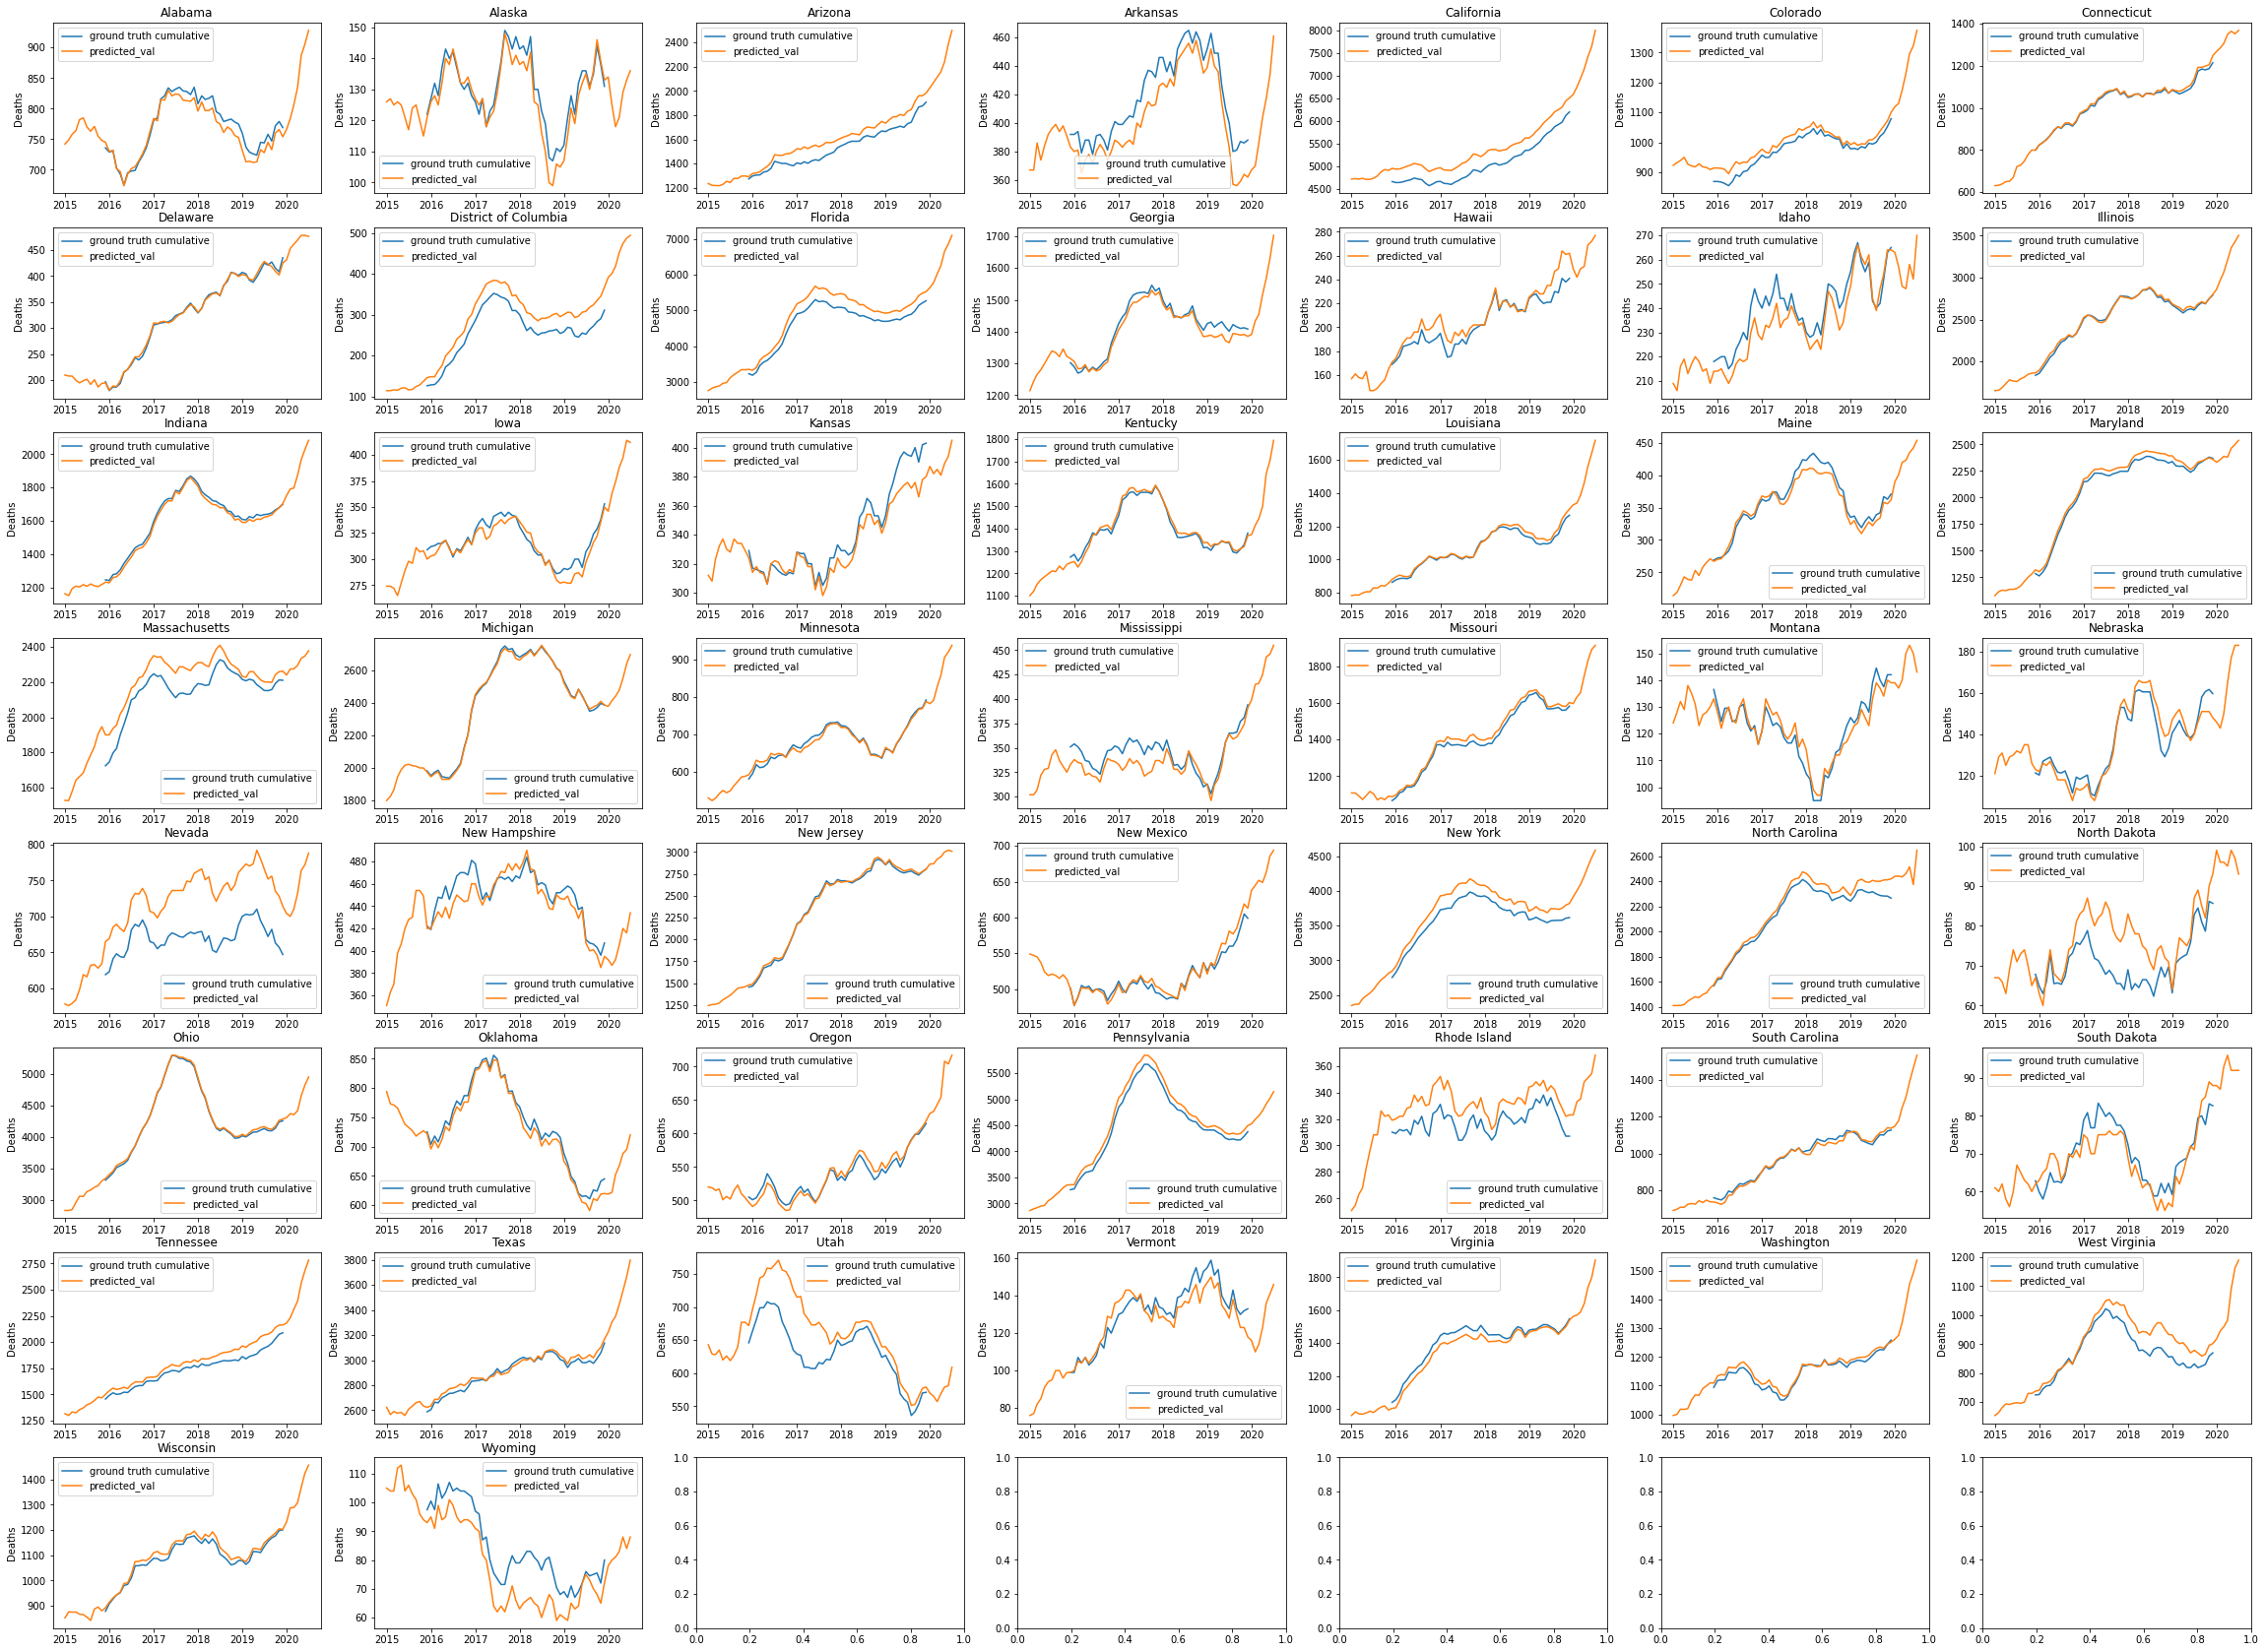

In [10]:
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(40,30))
i = 0
for loc, loc_data in data.groupby('location'):
    ax=axes.flatten()[i]
    int_loc = loc_data.loc[loc_data.Deaths != 'Suppressed']
    int_loc.Deaths = int_loc.Deaths.rolling(12).sum()
    sns.lineplot(
        y='Deaths',
        x='timestamp',
        data=int_loc,
        label='ground truth cumulative',
        ax=ax,
    )
    sns.lineplot(
        y='predicted_val',
        label='predicted_val',
        x='timestamp',
        data=int_loc,
        ax=ax
    )
    ax.vlines(loc_data.loc[loc_data.Deaths == 'Suppressed', 'timestamp'], *ax.get_ylim(), lw=1, alpha=.5, color='red')
    ax.set_title(loc)
    ax.set_xlabel('')

    i+=1


## Calculate prediction error at n-months out from 11 months of ground truth data used

In [11]:
importlib.reload(ee)
error_data = ee.calculate_error(data, max_months_out = 13)
error_data.to_csv('output/full_error.csv', index=False)
error_data

,location,pred_timestamp,truth,error,pred,percent_error,month_out
0,Alabama,2015-12-01,51.0,-9.0,60.0,17.647059,1
663,Alabama,2016-01-01,58.0,-1.0,59.0,1.724138,1
1,Alabama,2016-01-01,58.0,8.0,50.0,13.793103,2
1326,Alabama,2016-02-01,62.0,-1.0,63.0,1.612903,1
664,Alabama,2016-02-01,62.0,0.0,62.0,0.000000,2
...,...,...,...,...,...,...,...
28507,Wyoming,2020-05-01,NaN,NaN,9.0,NaN,12
27845,Wyoming,2020-05-01,NaN,NaN,4.0,NaN,13
29170,Wyoming,2020-06-01,NaN,NaN,3.0,NaN,12
28508,Wyoming,2020-06-01,NaN,NaN,3.0,NaN,13


In [12]:
error_data[~error_data.error.isna()].pred_timestamp.nunique()

49

In [13]:
error_data.groupby('month_out').error.describe()

,count,mean,std,min,25%,50%,75%,max
month_out,,,,,,,,
1,2244.0,-26.965241,66.771029,-385.0,-28.25,-5.0,5.000000,59.0
2,2244.0,-0.233512,5.744853,-34.0,-3.00,0.0,2.541667,34.0
3,2244.0,-0.208111,5.748544,-34.0,-3.00,0.0,3.000000,34.0
4,2244.0,-0.243761,5.768243,-34.0,-3.00,0.0,3.000000,34.0
5,2244.0,-0.180036,5.779424,-34.0,-3.00,0.0,3.000000,34.0
6,2244.0,-0.146168,5.843416,-34.0,-3.00,0.0,3.000000,34.0
7,2193.0,-0.133607,5.848517,-34.0,-3.00,0.0,3.000000,34.0
8,2142.0,-0.125584,5.873718,-34.0,-3.00,0.0,3.000000,34.0
9,2091.0,-0.109995,5.875090,-34.0,-3.00,0.0,3.000000,34.0


<AxesSubplot:xlabel='percent_error', ylabel='location'>

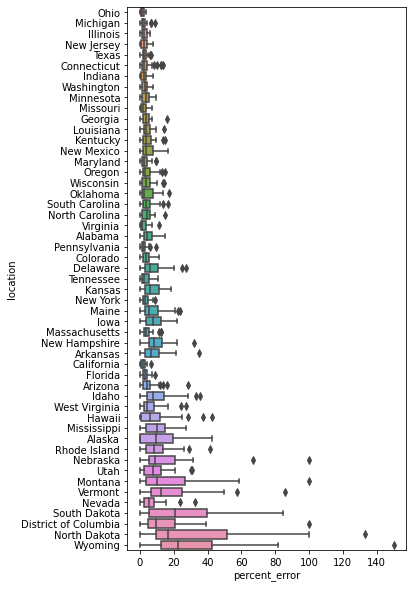

In [14]:
fig, ax = plt.subplots(figsize=(5,10))
m_last_error = error_data[error_data.month_out == 8]
order = error_data.groupby('location').percent_error.mean().sort_values().index
sns.boxplot(
    x='percent_error',
    y='location',
    data=m_last_error,
    order=order,
    ax=ax
)

## Summarize prediction error

In [15]:
stds = error_data.groupby(['location', 'month_out']).error.std()
abs_mean = error_data.groupby(['location', 'month_out']).error.apply(lambda x: np.mean(np.abs(x)))
mape = error_data.groupby(['location', 'month_out']).percent_error.apply(lambda x: np.mean(np.abs(x)))
std_pe = error_data.groupby(['location', 'month_out']).percent_error.std()
error_summary = pd.DataFrame(stds).rename(columns={'error': 'Std Error'}).reset_index().merge(
    pd.DataFrame(abs_mean).rename(columns={'error': 'Mean Absolute Error'}).reset_index()

).merge(
    pd.DataFrame(mape).rename(columns={'percent_error': 'Mean Absolute Percent Error'}).reset_index()
).merge(
    pd.DataFrame(std_pe).rename(columns={'percent_error': 'Std Percent Error'}).reset_index()
)
error_summary.to_csv('output/prediction_error_summary.csv', index=False)
error_summary

,location,month_out,Std Error,Mean Absolute Error,Mean Absolute Percent Error,Std Percent Error
0,Alabama,1,9.589541,10.704545,17.427589,13.833549
1,Alabama,2,4.278122,3.500000,5.585902,4.140696
2,Alabama,3,4.119964,3.340909,5.315304,3.977712
3,Alabama,4,4.134818,3.386364,5.375910,3.914658
4,Alabama,5,4.127974,3.363636,5.325968,3.947522
...,...,...,...,...,...,...
658,Wyoming,9,2.303695,1.780488,30.702975,29.659845
659,Wyoming,10,2.192060,1.700000,29.684835,29.303110
660,Wyoming,11,2.214006,1.717949,30.018634,29.609031
661,Wyoming,12,2.238452,1.736842,30.432659,29.891860
